In [1]:
!pip install tensorflow==2.15.0
!pip install keras==2.15.0


!pip install imageio
!pip install opencv-python

In [2]:
# import neccessary libraries
from keras.layers import UpSampling2D, Reshape, Activation, Conv2D, BatchNormalization, LeakyReLU, Input, Flatten, multiply, Embedding
from keras.optimizers import Adam
from keras.models import Sequential, Model
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
from keras.layers import ZeroPadding2D
from keras.layers import Concatenate


from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

import time


import cv2
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam as LegacyAdam
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.optimizers import Adam as LegacyAdam
import tensorflow as tf  


import glob
import imageio
from tensorflow.keras import layers
from IPython import display

In [3]:
# Function to load images from a directory

# Define the paths
brain_tumor_path = "C:\\Users\\net pc\\Desktop\\DATA SCIENCE JOURNEY\\Python files\\BRAIN TUMOR JPG IMAGES ENHANCED"

# Function to load and resize images
def load_and_resize_images(folder_path, target_size=(64, 64)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img = img.resize(target_size, Image.ANTIALIAS)
            img_array = np.array(img)
            images.append(img_array)
    return np.array(images)

# Load and resize brain tumor images
brain_tumor_images = load_and_resize_images(brain_tumor_path)



# Print the shapes for verification
print("Brain tumor images shape:", brain_tumor_images.shape)




C:\Users\net pc\AppData\Local\Temp\ipykernel_19348\925402422.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


Brain tumor images shape: (1000, 64, 64)


In [4]:
brain_tumor_images = brain_tumor_images.reshape(brain_tumor_images.shape[0], 64, 64, 1).astype('float32')
brain_tumor_images = (brain_tumor_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [5]:

BATCH_SIZE = 32 

# batch and shuffle data
brain_tumor_images = tf.data.Dataset.from_tensor_slices(brain_tumor_images).shuffle(len(brain_tumor_images)).batch(BATCH_SIZE)



In [6]:
brain_tumor_images

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)>

# Create the models

#### Both the generator and discriminator are defined using the Keras Sequential API

## The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x1. 
Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

def make_generator_model():
    model = tf.keras.Sequential()
    
    # Fully connected layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Activation("relu"))

    # Reshape to a 3D tensor
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)   # Note: None is the batch size
    model.add(layers.Activation("relu"))

    # Upsample to 16x16x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 32x32x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.LeakyReLU())

    # Upsample to 64x64x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model



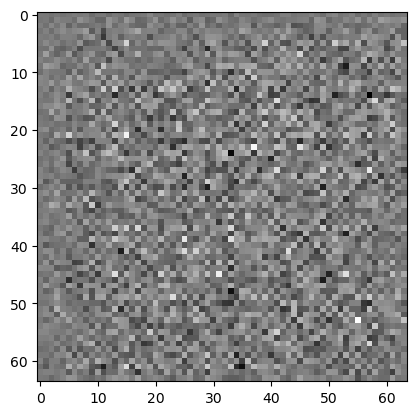

In [31]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # Fully connected layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to a 3D tensor
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    # Upsample to 16x16x128
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 32x32x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 64x64x1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model

# Create the generator model
generator = make_generator_model()

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Generate a random noise vector
noise = tf.random.normal([1, 100])

# Generate an image using the generator
generated_image = generator(noise, training=False)

# Display the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()


### Use the (as yet untrained) generator to create an image.

In [ ]:
# Create the generator model
generator = make_generator_model()

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Generate a random noise vector
noise = tf.random.normal([1, 100])

# Generate an image using the generator
generated_image = generator(noise, training=False)

# Display the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()



## The Discriminator

The discriminator is a CNN-based image classifier.

In [32]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model
     
    
   


    #
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

### Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [33]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5000941]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers
Define loss functions and optimizers for both models.

In [34]:

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
     

## Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [35]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
     

## Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [36]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we are training two networks separately.

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted

In [38]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [39]:
EPOCHS = 3000  
noise_dim = 100
num_examples_to_generate = 16  # The total number of synthetic images i want
save_interval=1000
#  will reuse this seed overtime 
# to visualize progress in the animated GIF)

seed = tf.random.normal([num_examples_to_generate, noise_dim])




The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.



In [40]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  


In [41]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Generate and save images

In [42]:

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):     
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()






# Train the model

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble the brain tumor data. This may take about one minute 


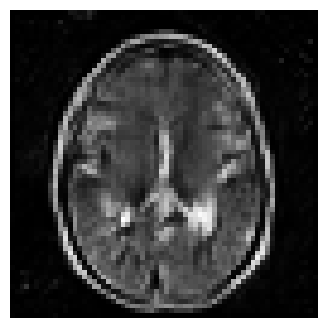

In [43]:
train(brain_tumor_images, EPOCHS)

Restore the latest checkpoint.

In [44]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [45]:
end = time.time()
elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                     int((end - start) % 60))
print(elapsed_train_time)

os.makedirs('saved_model_weights', exist_ok=True)
generator.save_weights('saved_model_weights/generator_weights.h5')
discriminator.save_weights('saved_model_weights/discriminator_weights.h5')
combined.save_weights('saved_model_weights/combined_weights.h5')

NameError: name 'start' is not defined